# Simple MNIST NN from scratch

In this notebook, I implemented a simple two-layer neural network and trained it on the MNIST digit recognizer dataset. It's meant to be an instructional example, through which you can understand the underlying math of neural networks better.

Here's a video I made explaining all the math and showing my progress as I coded the network: https://youtu.be/w8yWXqWQYmU

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
data = pd.read_csv('./train.csv')

In [4]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data) # shuffle before splitting into dev and training sets

data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]
X_dev = X_dev / 255.

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.
_,m_train = X_train.shape

In [5]:
Y_train

array([6, 2, 0, ..., 3, 4, 8], dtype=int64)

Our NN will have a simple two-layer architecture. Input layer $a^{[0]}$ will have 784 units corresponding to the 784 pixels in each 28x28 input image. A hidden layer $a^{[1]}$ will have 10 units with ReLU activation, and finally our output layer $a^{[2]}$ will have 10 units corresponding to the ten digit classes with softmax activation.

**Forward propagation**

$$Z^{[1]} = W^{[1]} X + b^{[1]}$$
$$A^{[1]} = g_{\text{ReLU}}(Z^{[1]}))$$
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$$
$$A^{[2]} = g_{\text{softmax}}(Z^{[2]})$$

**Backward propagation**

$$dZ^{[2]} = A^{[2]} - Y$$
$$dW^{[2]} = \frac{1}{m} dZ^{[2]} A^{[1]T}$$
$$dB^{[2]} = \frac{1}{m} \Sigma {dZ^{[2]}}$$
$$dZ^{[1]} = W^{[2]T} dZ^{[2]} .* g^{[1]\prime} (z^{[1]})$$
$$dW^{[1]} = \frac{1}{m} dZ^{[1]} A^{[0]T}$$
$$dB^{[1]} = \frac{1}{m} \Sigma {dZ^{[1]}}$$

**Parameter updates**

$$W^{[2]} := W^{[2]} - \alpha dW^{[2]}$$
$$b^{[2]} := b^{[2]} - \alpha db^{[2]}$$
$$W^{[1]} := W^{[1]} - \alpha dW^{[1]}$$
$$b^{[1]} := b^{[1]} - \alpha db^{[1]}$$

**Vars and shapes**

Forward prop

- $A^{[0]} = X$: 784 x m
- $Z^{[1]} \sim A^{[1]}$: 10 x m
- $W^{[1]}$: 10 x 784 (as $W^{[1]} A^{[0]} \sim Z^{[1]}$)
- $B^{[1]}$: 10 x 1
- $Z^{[2]} \sim A^{[2]}$: 10 x m
- $W^{[1]}$: 10 x 10 (as $W^{[2]} A^{[1]} \sim Z^{[2]}$)
- $B^{[2]}$: 10 x 1

Backprop

- $dZ^{[2]}$: 10 x m ($~A^{[2]}$)
- $dW^{[2]}$: 10 x 10
- $dB^{[2]}$: 10 x 1
- $dZ^{[1]}$: 10 x m ($~A^{[1]}$)
- $dW^{[1]}$: 10 x 10
- $dB^{[1]}$: 10 x 1

In [6]:
def init_params():
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A
    
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2

In [7]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print("epoch: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    return W1, b1, W2, b2

In [8]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.10, 500)

Iteration:  0
[9 7 9 ... 5 9 9] [6 2 0 ... 3 4 8]
0.10058536585365854
Iteration:  10
[6 3 9 ... 5 9 9] [6 2 0 ... 3 4 8]
0.1965609756097561
Iteration:  20
[6 3 9 ... 5 3 9] [6 2 0 ... 3 4 8]
0.28241463414634144
Iteration:  30
[6 3 4 ... 3 3 9] [6 2 0 ... 3 4 8]
0.3582439024390244
Iteration:  40
[6 3 4 ... 3 3 9] [6 2 0 ... 3 4 8]
0.41229268292682925
Iteration:  50
[6 3 4 ... 3 3 9] [6 2 0 ... 3 4 8]
0.4563658536585366
Iteration:  60
[6 1 4 ... 3 3 9] [6 2 0 ... 3 4 8]
0.49102439024390243
Iteration:  70
[2 1 4 ... 3 3 9] [6 2 0 ... 3 4 8]
0.5199024390243903
Iteration:  80
[2 1 0 ... 3 5 9] [6 2 0 ... 3 4 8]
0.5481951219512196
Iteration:  90
[2 1 0 ... 3 5 9] [6 2 0 ... 3 4 8]
0.5716341463414634
Iteration:  100
[2 1 0 ... 3 5 9] [6 2 0 ... 3 4 8]
0.5933658536585366
Iteration:  110
[2 2 0 ... 3 5 9] [6 2 0 ... 3 4 8]
0.6132682926829268
Iteration:  120
[2 2 0 ... 3 4 9] [6 2 0 ... 3 4 8]
0.6319024390243903
Iteration:  130
[2 2 0 ... 3 4 9] [6 2 0 ... 3 4 8]
0.6475365853658537
Iteration:  1

~85% accuracy on training set.

In [9]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Let's look at a couple of examples:

Prediction:  [6]
Label:  6


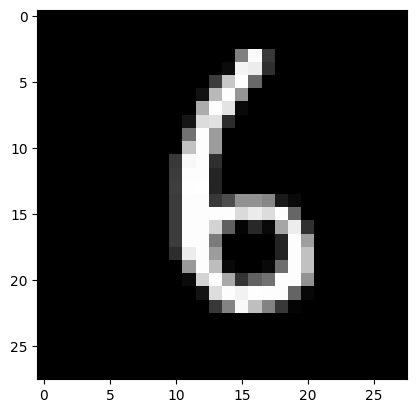

Prediction:  [2]
Label:  2


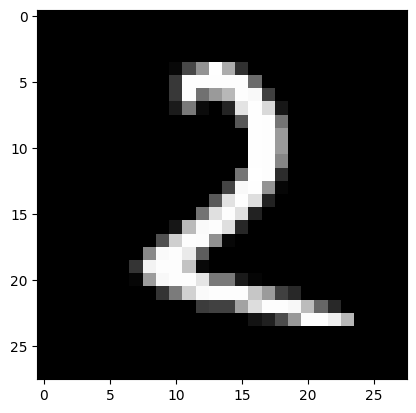

Prediction:  [0]
Label:  0


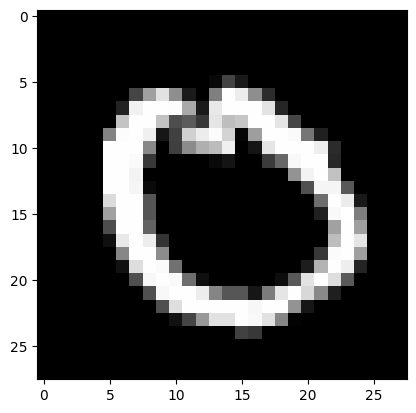

Prediction:  [9]
Label:  9


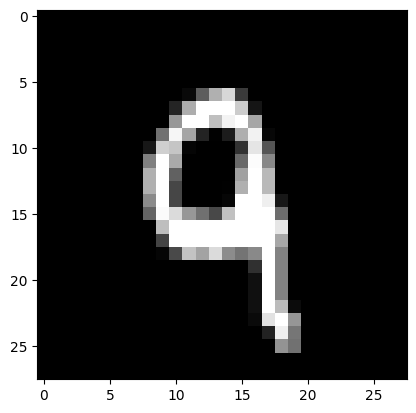

In [10]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)

Finally, let's find the accuracy on the dev set:

In [11]:
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)
get_accuracy(dev_predictions, Y_dev)

[8 2 1 8 9 6 2 1 2 0 8 8 3 4 4 1 7 3 0 7 2 6 6 5 8 0 1 5 3 5 3 6 0 3 4 8 7
 9 6 6 1 7 1 6 4 9 8 5 1 5 3 0 1 0 3 5 6 3 5 8 9 5 2 4 4 1 0 9 8 8 4 9 9 7
 4 3 8 9 2 3 7 0 8 6 8 7 0 4 2 5 7 5 6 4 3 5 4 6 8 5 3 4 2 2 6 2 9 3 1 4 5
 9 4 5 7 6 5 9 3 5 1 0 4 8 4 5 8 0 3 9 1 8 1 6 9 6 6 8 8 6 0 6 9 4 3 0 6 4
 2 9 8 1 1 3 7 9 6 8 2 1 5 3 2 9 1 7 2 7 3 9 3 4 8 1 2 5 8 3 8 2 7 7 4 0 3
 3 9 1 7 1 6 1 2 1 6 3 8 2 7 1 3 3 5 1 3 4 6 3 3 1 6 4 2 2 8 2 3 9 3 3 7 8
 2 0 6 4 6 8 9 4 7 2 2 7 9 8 3 6 0 0 2 6 2 7 9 9 0 5 1 1 8 1 3 6 8 0 0 7 9
 9 0 9 3 6 0 5 1 9 2 6 1 6 3 9 4 0 8 2 4 8 9 4 4 0 6 7 8 2 0 5 4 2 1 4 9 2
 1 1 8 1 8 1 4 5 0 8 0 1 1 1 4 5 4 7 0 6 9 3 5 6 7 4 3 6 5 9 0 8 5 9 0 4 4
 9 0 0 0 8 4 7 1 0 3 4 1 3 7 0 3 0 9 2 0 4 5 1 8 5 3 1 9 7 2 4 8 0 4 4 3 6
 2 8 8 4 0 1 1 9 3 5 2 1 5 8 8 8 3 4 3 5 9 0 0 0 8 3 8 9 4 7 1 8 0 7 8 1 2
 3 9 4 7 5 9 2 4 2 0 1 9 2 5 3 0 1 6 3 1 2 1 8 5 3 1 1 3 8 7 2 9 2 9 9 0 8
 5 9 8 6 7 8 0 1 0 4 4 7 4 3 5 7 0 6 2 0 7 1 0 7 4 2 7 6 5 6 2 4 7 4 4 5 1
 1 0 1 7 7 3 1 4 2 6 8 1 

0.832

Still 84% accuracy, so our model generalized from the training data pretty well.